# SHAP 튜토리얼: 모델 불가지론적 방법으로 모델 해석 (Model Agnostic Explanations)
  - SHapley Additive exPlanations, SHAP
  - Red Wine Quality 예측 문제
  ## Index
 
 1) 실습 환경 만들기
 
 2) 따라하기: SHAP 실습
 
 3) 적용하기: SHAP 활용

## 실습 환경 만들기 Google Colab

## SHAP 모듈 설치 방법
### 설치 방법 - PyPI로 설치 (pip install)

In [2]:
# SHAP 모듈 설치
!pip install shap

     |████████████████████████████████| 235kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=344741 sha256=3ff4d232729f0f800f5c1580fee7d8bb5bb83462e8080e30bc457593bda9f38d
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap


### 구글 드라이브와 Colab 연동

In [50]:
# 구글 드라이브와 Colab 연동
from google.colab import drive
drive.mount('/content/drive') # 출력되는 URL에 접속하여 verification code 복사 및 붙여넣기

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
# 작업할 공간 설정
import os
os.getcwd() # 현재 path 확인

'/content'

In [12]:
# 현재 path에 존재하는 파일 목록 확인
os.listdir(os.getcwd())

['.config', '.ipynb_checkpoints', 'drive', 'sample_data']

In [0]:
# 작업 공간 설정
os.chdir('/content/drive/My Drive/PyConKorea2019/') #  작업할 path를 현재 path로 변경

In [14]:
os.getcwd() # 현재 path 확인

'/content/drive/My Drive/PyConKorea2019'

In [15]:
# 현재 path에 존재하는 파일 목록 확인
os.listdir(os.getcwd())

['shap',
 'old',
 'winequality-red.csv',
 '참고자료',
 'Check List.gsheet',
 'mnist_cnn_model.h5',
 'SHAP-tutorial.ipynb']

# 따라하기: SHAP 실습

## DeepExplainer

In [11]:
# 사용할 패키지 불러오기
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# 데이터셋 불러와서 훈련셋과 검증셋 분리
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터셋 전처리
img_rows, img_cols = 28, 28 # 입력 이미지 차원
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 원핫인코딩 (one-hot encoding) 처리
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 모델 구성
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# 모델 학습과정 설정
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# 모델 학습
batch_size = 128
epochs = 2
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# 모델 평가
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 모델 저장
from keras.models import load_model
model.save('mnist_cnn_model.h5')

Using TensorFlow backend.
W0808 11:48:48.953973 140532307986304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 11:48:48.968613 140532307986304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 11:48:48.973582 140532307986304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 11:48:49.000718 140532307986304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0808 11:48:49.004986 1405323

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


W0808 11:48:49.177975 140532307986304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 136s 2ms/step - loss: 0.2696 - acc: 0.9175 - val_loss: 0.0569 - val_acc: 0.9817
Epoch 2/2
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0860 - acc: 0.9745 - val_loss: 0.0366 - val_acc: 0.9873
Test loss: 0.03655668206337723
Test accuracy: 0.9873


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


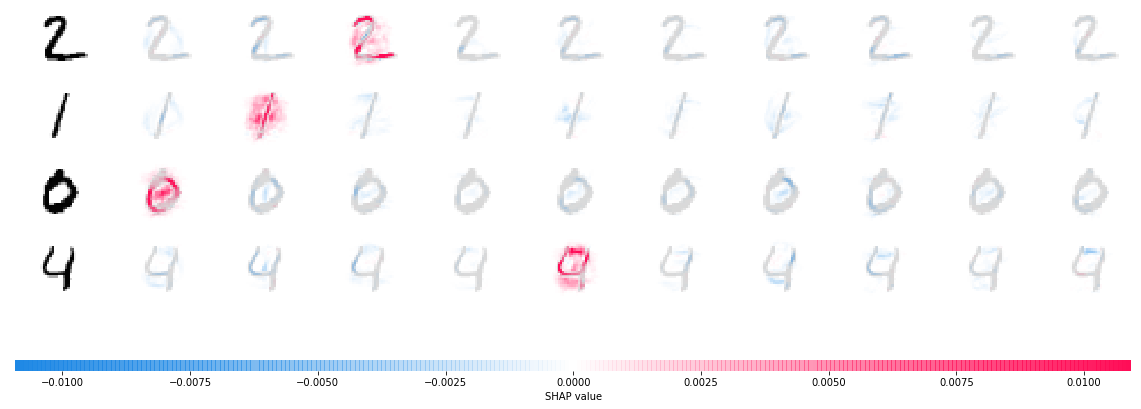

In [13]:
import shap
import numpy as np

# 데이터 불러오기 및 전처리
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

from keras import backend as K
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 모델 불러오기
from keras.models import load_model
model = load_model('mnist_cnn_model.h5')

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

## KernelExplainer
An implementation of Kernel SHAP, a model agnostic method to estimate SHAP values for any model. Because it makes not assumptions about the model type, KernelExplainer is slower than the other model type specific algorithms.

Iris classification - A basic demonstration using the popular iris species dataset. It explains predictions from six different models in scikit-learn using shap.

### Iris classification with scikit-learn
Here we use the well-known Iris species dataset to illustrate how SHAP can explain the output of many different model types, from k-nearest neighbors, to neural networks. This dataset is very small, with only a 150 samples. We use a random set of 130 for training and 20 for testing the models. Because this is a small dataset with only a few features we use the entire training dataset for the background. In problems with more features we would want to pass only the median of the training dataset, or weighted k-medians. While we only have a few samples, the prediction problem is fairly easy and all methods acheive perfect accuracy. What's interesting is how different methods sometimes rely on different sets of features for their predictions.

In [0]:
# Load data
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time

X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

# rather than use the whole training set to estimate expected values, we could summarize with
# a set of weighted kmeans, each weighted by the number of points they represent. But this dataset
# is so small we don't worry about it
#X_train_summary = shap.kmeans(X_train, 50)

def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

In [5]:
## Logistic regression
linear_lr = sklearn.linear_model.LogisticRegression()
linear_lr.fit(X_train, Y_train)
print_accuracy(linear_lr.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(linear_lr.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy = 96.66666666666667%


W0809 08:43:29.144898 140518053918592 kernel.py:108] Using 120 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/li

/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/li

In [6]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

## TreeExplainer
While SHAP values can explain the output of any machine learning model, we have developed a high-speed exact algorithm for tree ensemble methods (Tree SHAP arXiv paper). Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, and scikit-learn tree models:

In [7]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

## Red Wine Quality

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# imports
import pandas as pd
import numpy as np

# Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 

# Some Scikit-learn utils
from sklearn.model_selection import train_test_split

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

# Models
from xgboost import XGBClassifier, plot_importance

# Some cosmetics add-ons
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [18]:
# loading the csv dataset in a dataframe
df_raw = pd.read_csv('/content/drive/My Drive/PyConKorea2019/winequality-red.csv')
df_raw.shape

(1599, 12)

In [0]:
# make for security a copy of the original dataframe before further processing 
wines = df_raw.copy()

In [0]:
# Extracting our target variable 
# and creating a usefull feature list of dependant variables
target = 'quality'
features_list = list(wines.columns)
features_list.remove(target)

In [21]:
# create our separate target vector 
y = wines.pop('quality')

# mapping the target to a binary class at quality = 5
y = y.apply(lambda x: 0 if x <= 5 else 1)

# quickly check that we have a balanced target partition
y.sum() / len(y)

0.5347091932457786

In [22]:
# building train/test datasets on a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(wines, y, test_size=0.3, random_state=33)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## Training our classification model

In [23]:
# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
%time xgb.fit(X_train, y_train)

CPU times: user 138 ms, sys: 5.89 ms, total: 144 ms
Wall time: 83 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Prediction and Evaluation of performance

In [0]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

In [0]:
# We design a simple classification evaluative function
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame)

In [26]:
# Evaluate predictions
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 0.7521
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  Low Quality       0.73      0.74      0.73       221
Hight Quality       0.78      0.76      0.77       259

     accuracy                           0.75       480
    macro avg       0.75      0.75      0.75       480
 weighted avg       0.75      0.75      0.75       480

------------------------------------------------------------
Confusion matrix:

          Predicted:     
                   0    1
Actual: 0        164   57
        1         62  197


## Model Interpretation with SHAP

In [27]:
# load JS visualization code to notebook
shap.initjs()

In [28]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
print('Expected Value: ', explainer.expected_value)

Expected Value:  0.14833762


## Feature Importances with SHAP

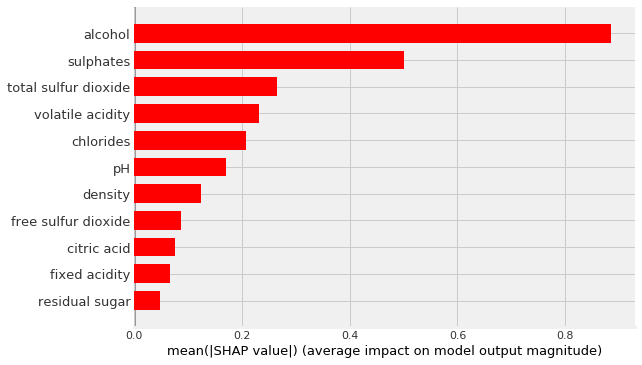

In [29]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:])

### Visualizing and explaining multiple predictions

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

## SHAP Summary Plot

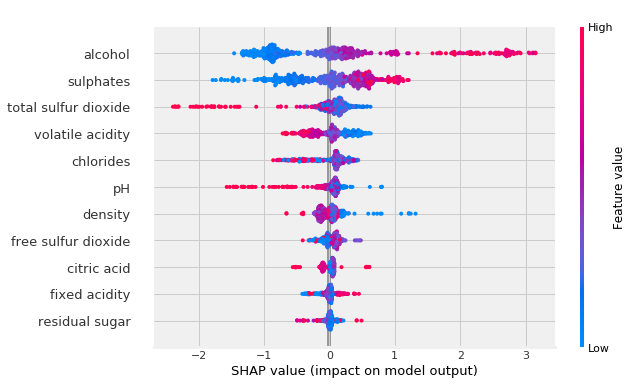

In [33]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

## SHAP Dependence Plots
### PD plot of 'pH' (and influence of 'fixed acidity') affecting model prediction

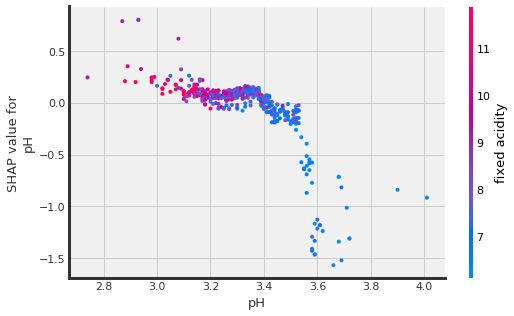

In [34]:
shap.dependence_plot(ind='pH', interaction_index='fixed acidity',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)